# Edge Connect

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch.nn.functional as F

In [2]:
# Define the EdgeConnect model
class EdgeConnect(nn.Module):
    def __init__(self):
        super(EdgeConnect, self).__init__()
        self.edge_model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=5, padding=2),  # Input: 4 channels (img + mask), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 1, kernel_size=5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.completion_model = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=5, padding=2),  # Input: 5 channels (img + mask + edges), Output: 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 3, kernel_size=5, padding=2),  # Output: 3 channels (RGB image)
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        edges = self.edge_model(x)  # Forward pass through the edge model

        # Upsample 'edges' to match the spatial dimensions of 'x'
        edges_upsampled = F.interpolate(edges, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        # Concatenate 'x' and the upsampled 'edges'
        completion = self.completion_model(torch.cat([x, edges_upsampled], dim=1))  
        return edges, completion

In [3]:
# Create an instance of the EdgeConnect model
model = EdgeConnect()

# Print the model summary
print(model)

EdgeConnect(
  (edge_model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Sigmoid()
  )
  (completion_model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05

To obtain a summary of the model's parameters, you can use the summary function from the torchsummary package. However, the torchsummary package currently supports summarizing models with a single input shape and does not handle models with multiple inputs or complex branching structures.

In the case of the EdgeConnect model, which has multiple inputs (corr_img and mask) and a complex architecture, we can manually compute and print the number of parameters at each level of the model using the following code:

In [4]:
def count_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            print(f"{name}: {num_params}")
            total_params += num_params
    print(f"Total Parameters: {total_params}")

# Print the model's parameter summary
count_parameters(model)

edge_model.0.weight: 6400
edge_model.0.bias: 64
edge_model.1.weight: 64
edge_model.1.bias: 64
edge_model.3.weight: 204800
edge_model.3.bias: 128
edge_model.4.weight: 128
edge_model.4.bias: 128
edge_model.6.weight: 819200
edge_model.6.bias: 256
edge_model.7.weight: 256
edge_model.7.bias: 256
edge_model.10.weight: 6400
edge_model.10.bias: 1
edge_model.11.weight: 1
edge_model.11.bias: 1
completion_model.0.weight: 8000
completion_model.0.bias: 64
completion_model.1.weight: 64
completion_model.1.bias: 64
completion_model.3.weight: 204800
completion_model.3.bias: 128
completion_model.4.weight: 128
completion_model.4.bias: 128
completion_model.6.weight: 819200
completion_model.6.bias: 256
completion_model.7.weight: 256
completion_model.7.bias: 256
completion_model.10.weight: 19200
completion_model.10.bias: 3
completion_model.11.weight: 3
completion_model.11.bias: 3
Total Parameters: 2090700


In [5]:
# Set the root directory of your dataset
root_dir = 'new_data'

# Define the transforms to apply to the images and masks
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images and masks to tensors
    transforms.Resize((256, 256)),  # Resize images and masks to the target size
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  # Apply min-max normalization
])

class InpaintingDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        # Only include files in the directory, not subdirectories
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.split(".")[0] + "_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        # Add mask channel to the image
        img_with_mask = torch.cat((img, mask), dim=0)
        
        return img_with_mask, mask


In [6]:
# Define the training and testing datasets
train_dataset = InpaintingDataset(os.path.join(root_dir, 'original', 'train'),
                                  os.path.join(root_dir, 'mask', 'train'),
                                  transform=transform)

test_dataset = InpaintingDataset(os.path.join(root_dir, 'original', 'test'),
                                 os.path.join(root_dir, 'mask', 'test'),
                                 transform=transform)

# Define the data loaders
batch_size = 8  # Set the desired batch size

# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Testing data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Define the Loss function
loss_function = nn.MSELoss()

# Define the optimizer

learning_rate = 0.001  # Set the learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EdgeConnect(
  (edge_model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Sigmoid()
  )
  (completion_model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05

In [8]:
# Train the model
num_epochs = 50  # Set the number of training epochs

model.train()

EdgeConnect(
  (edge_model): Sequential(
    (0): Conv2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Sigmoid()
  )
  (completion_model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05

In [9]:
for epoch in range(num_epochs):
    for i, (img_with_mask, mask) in enumerate(train_loader):
        img_with_mask, mask = img_with_mask.to(device), mask.to(device)
        
        # We only keep the first 3 channels of the input (RGB) for the loss calculation
        img = img_with_mask[:, :3, :, :]

        optimizer.zero_grad()

        edges, completion = model(img_with_mask)  # Forward pass
        # Upsample 'completion' to match the spatial dimensions of 'img'
        completion_upsampled = F.interpolate(completion, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False)
        loss = loss_function(completion_upsampled, img)  # Compute the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update the model's parameters

        if i % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}")

/nfs/home/lcz6414/.venv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/50], Step [1/63], Loss: 0.46521592140197754
Epoch [1/50], Step [11/63], Loss: 0.20494389533996582
Epoch [1/50], Step [21/63], Loss: 0.16650155186653137
Epoch [1/50], Step [31/63], Loss: 0.15275335311889648
Epoch [1/50], Step [41/63], Loss: 0.14237534999847412
Epoch [1/50], Step [51/63], Loss: 0.1340465396642685
Epoch [1/50], Step [61/63], Loss: 0.11890151351690292
Epoch [2/50], Step [1/63], Loss: 0.11043870449066162
Epoch [2/50], Step [11/63], Loss: 0.1230119913816452
Epoch [2/50], Step [21/63], Loss: 0.14478978514671326
Epoch [2/50], Step [31/63], Loss: 0.10331972688436508
Epoch [2/50], Step [41/63], Loss: 0.1571539342403412
Epoch [2/50], Step [51/63], Loss: 0.11790229380130768
Epoch [2/50], Step [61/63], Loss: 0.1388232707977295
Epoch [3/50], Step [1/63], Loss: 0.12615539133548737
Epoch [3/50], Step [11/63], Loss: 0.11808355897665024
Epoch [3/50], Step [21/63], Loss: 0.10257032513618469
Epoch [3/50], Step [31/63], Loss: 0.13681751489639282
Epoch [3/50], Step [41/63], Loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


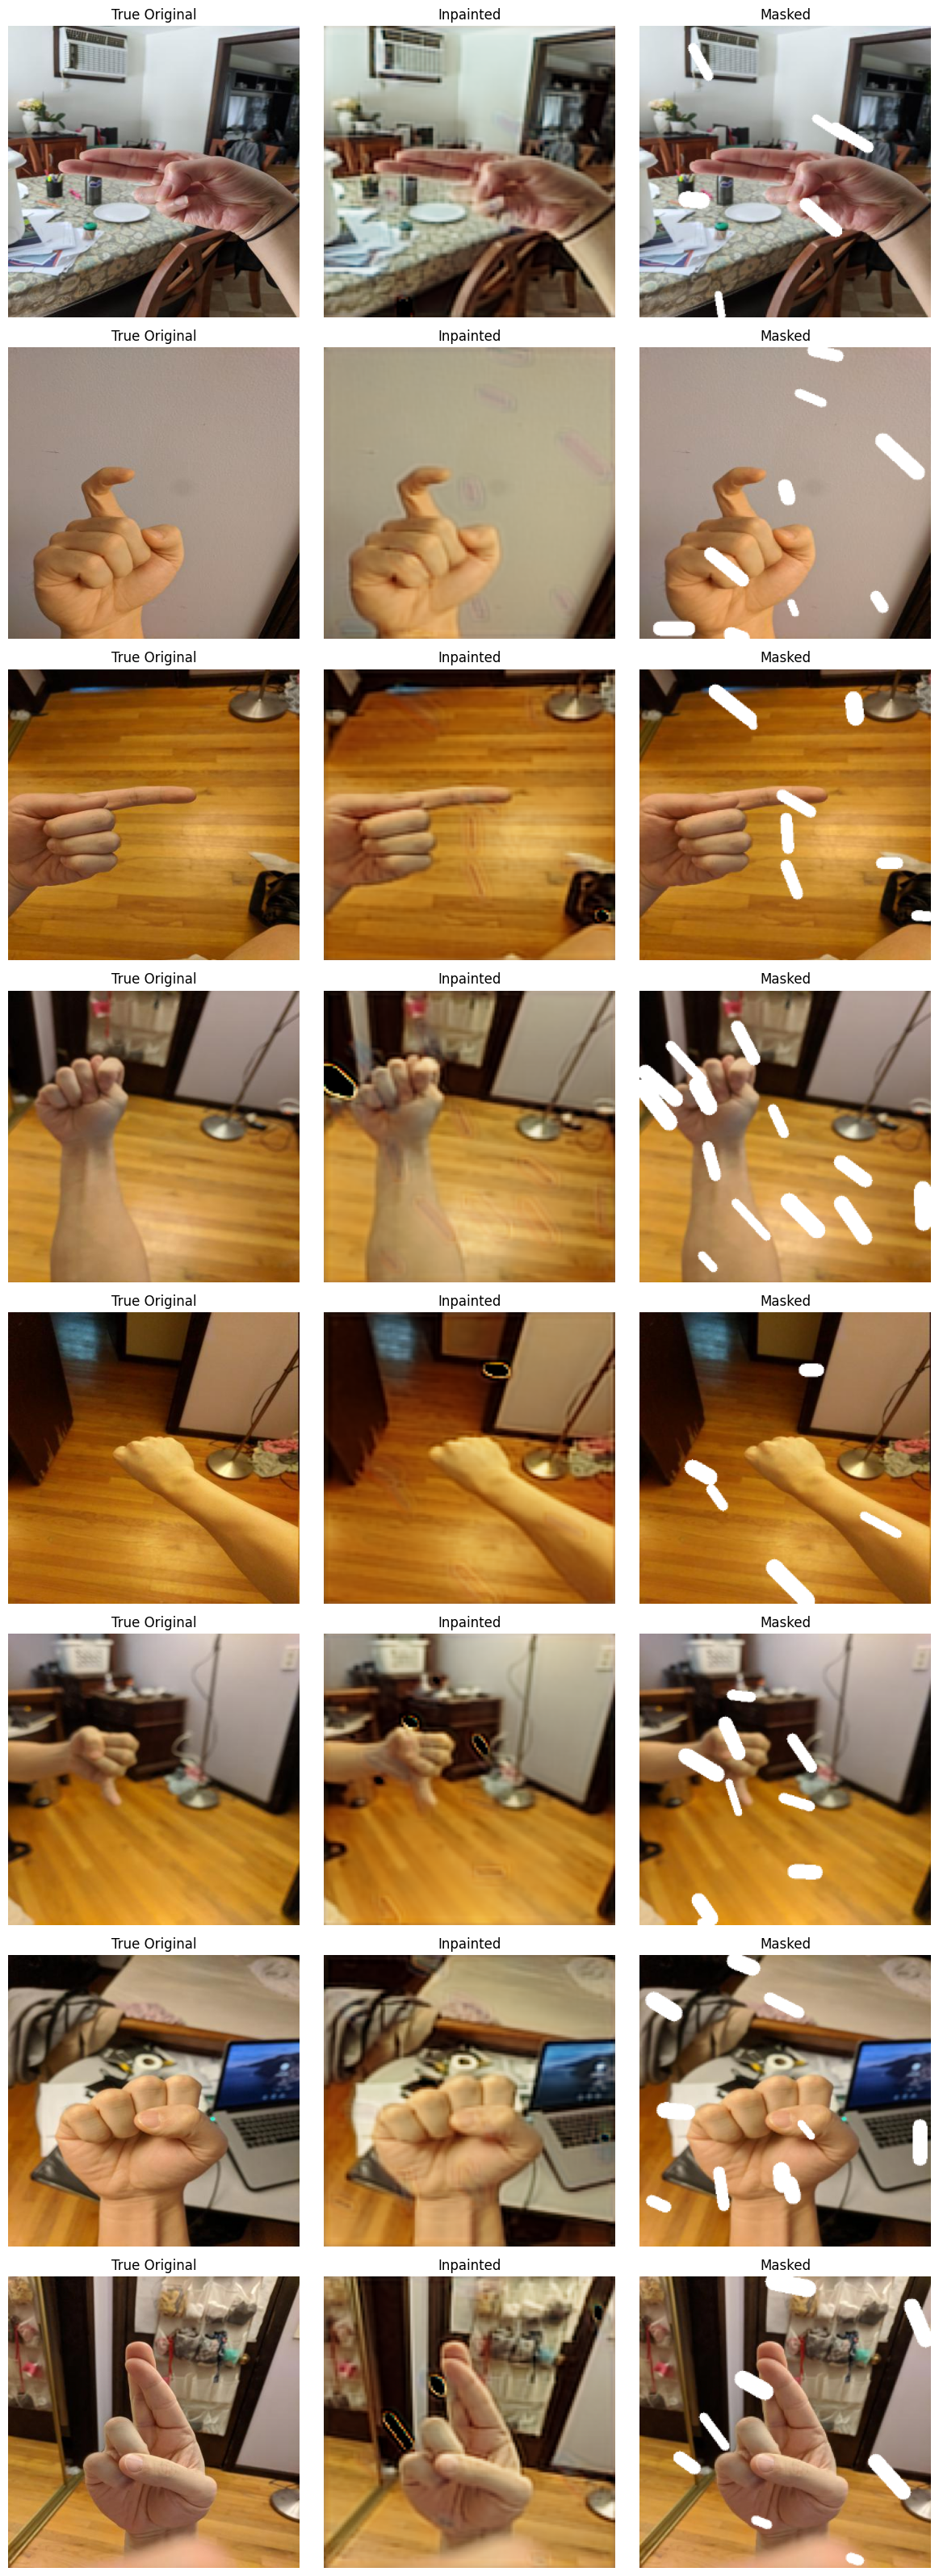

In [10]:
import os
from PIL import Image

# Set the model to evaluation mode
model.eval()

# Generate inpainted images
with torch.no_grad():
    for i, (img_with_mask, mask) in enumerate(test_loader):
        img_with_mask, mask = img_with_mask.to(device), mask.to(device)

        edges, completion = model(img_with_mask)  # Forward pass
        if i == 4:  # Display the 4th batch
            # Move the images back to the CPU and convert to numpy arrays
            img_with_mask = img_with_mask.cpu().numpy().transpose(0, 2, 3, 1)
            completion = completion.cpu().numpy().transpose(0, 2, 3, 1)
            mask = mask.cpu().numpy().transpose(0, 2, 3, 1)

            # Plot original, masked, and inpainted images
            fig, axs = plt.subplots(img_with_mask.shape[0], 3, figsize=(12, 4 * img_with_mask.shape[0]))
            for j in range(img_with_mask.shape[0]):
                img_name = test_dataset.image_files[i * test_loader.batch_size + j]
                img_path = os.path.join(test_dataset.image_dir, img_name)
                img = Image.open(img_path).convert("RGB")
                img = np.array(img)

                axs[j, 0].imshow(img)
                axs[j, 0].set_title("True Original")
                axs[j, 0].axis("off")
                axs[j, 2].imshow(img_with_mask[j])
                axs[j, 2].set_title("Masked")
                axs[j, 2].axis("off")
                axs[j, 1].imshow(completion[j])
                axs[j, 1].set_title("Inpainted")
                axs[j, 1].axis("off")

            plt.tight_layout()
            plt.show()

        if i >= 4:
            break
        #This code will display the modified image arrangement for the 4th batch of data. The second and third columns will be flipped, and the true original images will be displayed in the first column.


In [11]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model_checkpoint.pth')


In [ ]:
# Load the saved model checkpoint
model.load_state_dict(torch.load('model_checkpoint.pth'))
